<a href="https://colab.research.google.com/github/betul13/Ada_Lovelace_Akademi_Homework/blob/main/Heart_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Açıklama :
Bu projede, kalp krizi riskini belirlemek için makine öğrenimi modelleri geliştirilecektir.
Veri seti, kalp hastalığı varlığını ve yokluğunu gösteren hedef değişken ile birlikte çeşitli özellikler içerir.
Model geliştirme süreci, özellik seçimi, model eğitimi ve test etme aşamalarını içerecek. Makine öğreniminin açıklanabilirliği,
modelin karar verme sürecinin şeffaflığını artıracak ve hastalığın potansiyel risk faktörlerine dair içgörüler sağlayacaktır.
Sonuç olarak, bu çalışma, kalp krizi riskini tahmin etmede makine öğreniminin potansiyelini ortaya koymayı amaçlamaktadır.

In [22]:
# import işlemleri

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("/content/heart.csv")

In [5]:
"""
age: Hastanın yaşı
sex: Hastanın cinsiyeti (0: Kadın, 1: Erkek)
cp: Göğüs ağrısı tipi (0: Tipik Angina, 1: Atipik Angina, 2: Non-anginal Ağrı, 3: Asimptomatik)
trtbps: Dinlenme halindeki kan basıncı (mm Hg cinsinden)
chol: Kolestrol düzeyi (mg/dl, BMI sensörü aracılığıyla alınmış)
fbs: (Açlık kan şekeri > 120 mg/dl) (1: Doğru, 0: Yanlış)
restecg: Dinlenme elektrokardiyografik sonuçlar (0: Normal, 1: ST-T dalgası normalitesi, 2: Sol ventriküler hipertrofi)
thalachh: Ulaşılan maksimum kalp atış hızı
oldpeak: Önceki tepe
slp: Eğim
caa: Büyük damar sayısı
thall: Talium Stres Testi sonucu (0 ile 3 arasında)
exng: Egzersize bağlı anjina (1: Evet, 0: Hayır)
output: Hedef değişken (1: Kalp hastalığı var, 0: Kalp hastalığı yok)
"""
# Amaç veriyi hazır hale getirip bir kişinin kalp krizine yatkın olup olmadığını tahmin etmek.

'\nage: Hastanın yaşı\nsex: Hastanın cinsiyeti (0: Kadın, 1: Erkek)\ncp: Göğüs ağrısı tipi (0: Tipik Angina, 1: Atipik Angina, 2: Non-anginal Ağrı, 3: Asimptomatik)\ntrtbps: Dinlenme halindeki kan basıncı (mm Hg cinsinden)\nchol: Kolestrol düzeyi (mg/dl, BMI sensörü aracılığıyla alınmış)\nfbs: (Açlık kan şekeri > 120 mg/dl) (1: Doğru, 0: Yanlış)\nrestecg: Dinlenme elektrokardiyografik sonuçlar (0: Normal, 1: ST-T dalgası normalitesi, 2: Sol ventriküler hipertrofi)\nthalachh: Ulaşılan maksimum kalp atış hızı\noldpeak: Önceki tepe\nslp: Eğim\ncaa: Büyük damar sayısı\nthall: Talium Stres Testi sonucu (0 ile 3 arasında)\nexng: Egzersize bağlı anjina (1: Evet, 0: Hayır)\noutput: Hedef değişken (1: Kalp hastalığı var, 0: Kalp hastalığı yok)\n'

In [6]:
#################################################
# EDA
#################################################

def check_df(dataframe, head = 5):
    print("######################################  Shape  ##################################")
    print(dataframe.shape)
    print("######################################  Types  ##################################")
    print(dataframe.dtypes)
    print("######################################  Head  ###################################")
    print(dataframe.head(head))
    print("######################################  Tail  ###################################")
    print(dataframe.tail(head))
    print("#######################################  NA  ####################################")
    print(dataframe.isnull().sum())
    print("#######################################  Quantiles  #############################")
    print(dataframe.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T)


In [7]:
check_df(df)

######################################  Shape  ##################################
(303, 14)
######################################  Types  ##################################
age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object
######################################  Head  ###################################
   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      

In [8]:
#eksik verimiz yok kategorik ve nümerik değerlerimizi tespit edip değerlendirelim.

def grab_col_names(dataframe, cat_th = 10, car_th = 20):
        """

        Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
        Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

        Parameters
        ------
            dataframe: dataframe
                    Değişken isimleri alınmak istenilen dataframe
            cat_th: int, optional
                    numerik fakat kategorik olan değişkenler için sınıf eşik değeri
            car_th: int, optinal
                    kategorik fakat kardinal değişkenler için sınıf eşik değeri

        Returns
        ------
            cat_cols: list
                    Kategorik değişken listesi
            num_cols: list
                    Numerik değişken listesi
            cat_but_car: list
                    Kategorik görünümlü kardinal değişken listesi

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = toplam değişken sayısı
            num_but_cat cat_cols'un içerisinde.
            Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

        """

        # cat_cols, cat_but_car
        cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
        num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                       dataframe[col].dtypes != "O"]
        cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                       dataframe[col].dtypes == "O"]
        cat_cols = cat_cols + num_but_cat
        cat_cols = [col for col in cat_cols if col not in cat_but_car]

        # num_cols
        num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
        num_cols = [col for col in num_cols if col not in num_but_cat]
        return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th = 5, car_th = 20)

In [9]:
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe) }))
    print("#################################################################################")
    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block = True)

def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins = 20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col : "mean"}),end = "\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN" : dataframe.groupby(categorical_col)[target].mean()}) ,end = "\n\n\n")


count    303.000000
mean      54.366337
std        9.082101
min       29.000000
5%        39.100000
10%       42.000000
20%       45.000000
30%       50.000000
40%       53.000000
50%       55.000000
60%       58.000000
70%       59.000000
80%       62.000000
90%       66.000000
95%       68.000000
99%       71.000000
max       77.000000
Name: age, dtype: float64


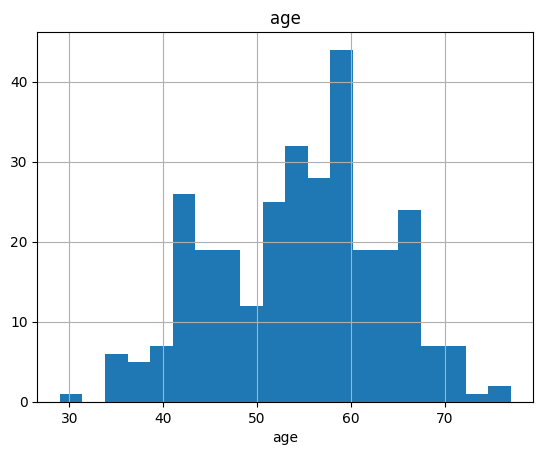

              age
output           
0       56.601449
1       52.496970


count    303.000000
mean     131.623762
std       17.538143
min       94.000000
5%       108.000000
10%      110.000000
20%      120.000000
30%      120.000000
40%      126.000000
50%      130.000000
60%      134.000000
70%      140.000000
80%      144.000000
90%      152.000000
95%      160.000000
99%      180.000000
max      200.000000
Name: trtbps, dtype: float64


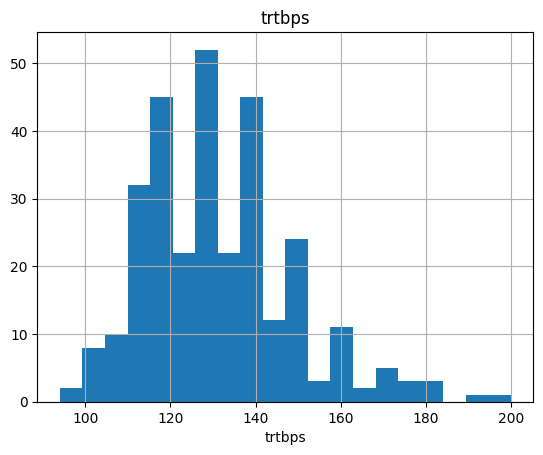

            trtbps
output            
0       134.398551
1       129.303030


count    303.000000
mean     246.264026
std       51.830751
min      126.000000
5%       175.000000
10%      188.000000
20%      204.000000
30%      217.600000
40%      230.000000
50%      240.000000
60%      254.000000
70%      268.000000
80%      285.200000
90%      308.800000
95%      326.900000
99%      406.740000
max      564.000000
Name: chol, dtype: float64


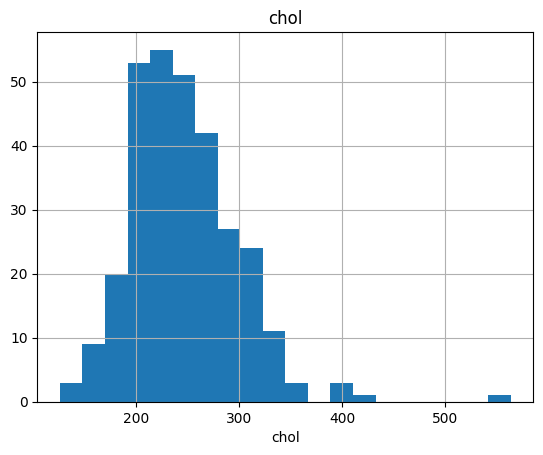

              chol
output            
0       251.086957
1       242.230303


count    303.000000
mean     149.646865
std       22.905161
min       71.000000
5%       108.100000
10%      116.000000
20%      130.000000
30%      140.600000
40%      146.000000
50%      153.000000
60%      159.000000
70%      163.000000
80%      170.000000
90%      176.600000
95%      181.900000
99%      191.960000
max      202.000000
Name: thalachh, dtype: float64


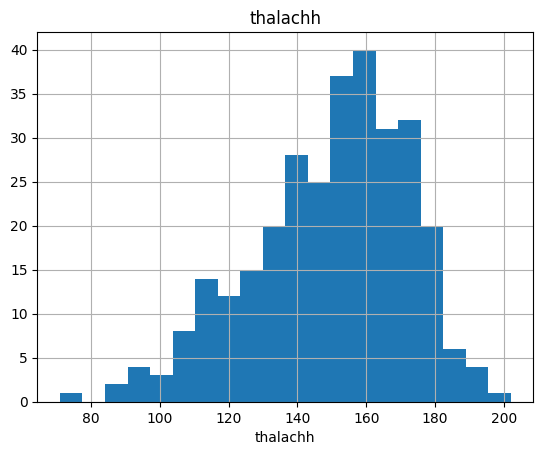

          thalachh
output            
0       139.101449
1       158.466667


count    303.000000
mean       1.039604
std        1.161075
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.380000
50%        0.800000
60%        1.120000
70%        1.400000
80%        1.900000
90%        2.800000
95%        3.400000
99%        4.200000
max        6.200000
Name: oldpeak, dtype: float64


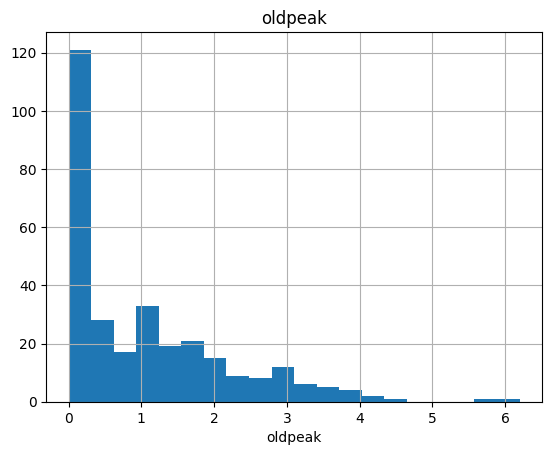

         oldpeak
output          
0       1.585507
1       0.583030


count    303.000000
mean       0.729373
std        1.022606
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%        0.000000
60%        1.000000
70%        1.000000
80%        2.000000
90%        2.000000
95%        3.000000
99%        4.000000
max        4.000000
Name: caa, dtype: float64


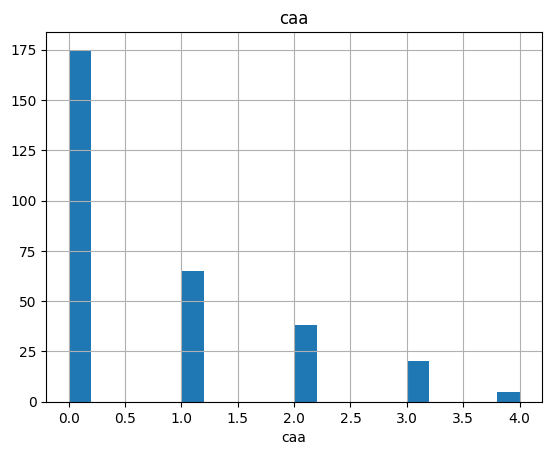

             caa
output          
0       1.166667
1       0.363636




In [10]:
for col in num_cols:
  num_summary(df, col, True)
  target_summary_with_num(df, "output", col)


   sex      Ratio
1  207  68.316832
0   96  31.683168
#################################################################################


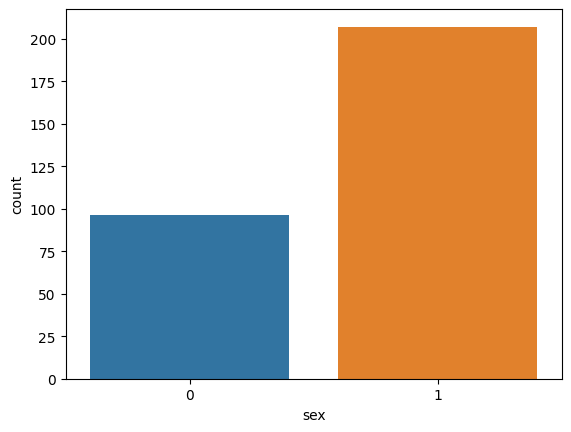

     TARGET_MEAN
sex             
0       0.750000
1       0.449275


    cp      Ratio
0  143  47.194719
2   87  28.712871
1   50  16.501650
3   23   7.590759
#################################################################################


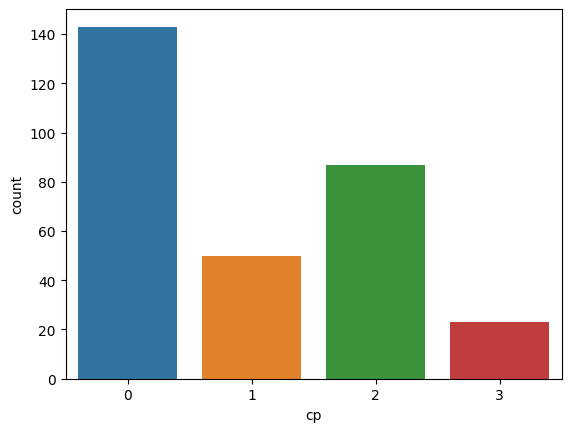

    TARGET_MEAN
cp             
0      0.272727
1      0.820000
2      0.793103
3      0.695652


   fbs      Ratio
0  258  85.148515
1   45  14.851485
#################################################################################


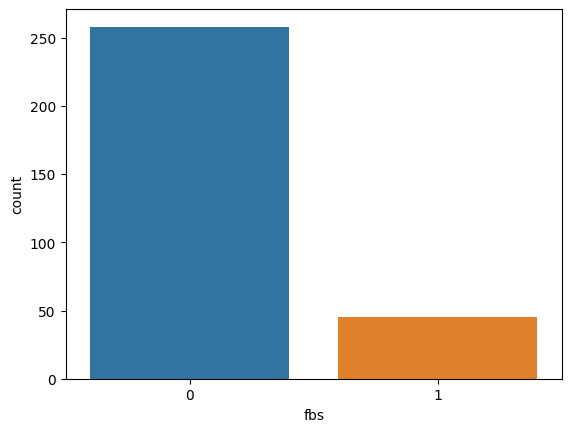

     TARGET_MEAN
fbs             
0       0.550388
1       0.511111


   restecg      Ratio
1      152  50.165017
0      147  48.514851
2        4   1.320132
#################################################################################


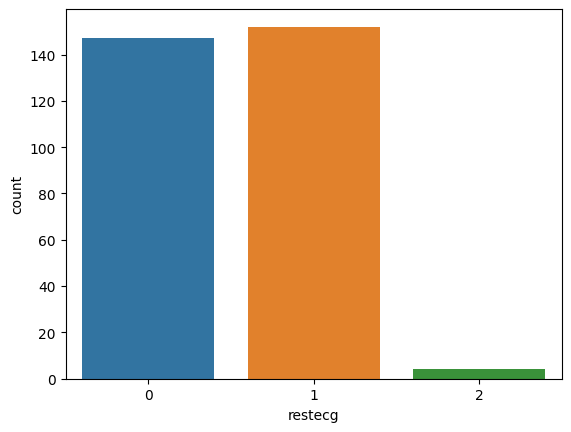

         TARGET_MEAN
restecg             
0           0.462585
1           0.631579
2           0.250000


   exng      Ratio
0   204  67.326733
1    99  32.673267
#################################################################################


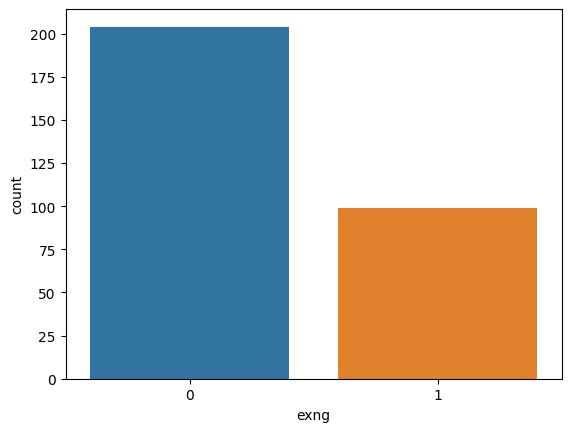

      TARGET_MEAN
exng             
0        0.696078
1        0.232323


   slp      Ratio
2  142  46.864686
1  140  46.204620
0   21   6.930693
#################################################################################


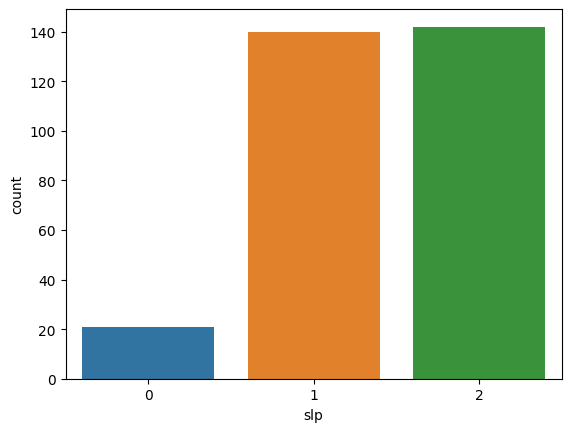

     TARGET_MEAN
slp             
0       0.428571
1       0.350000
2       0.753521


   thall      Ratio
2    166  54.785479
3    117  38.613861
1     18   5.940594
0      2   0.660066
#################################################################################


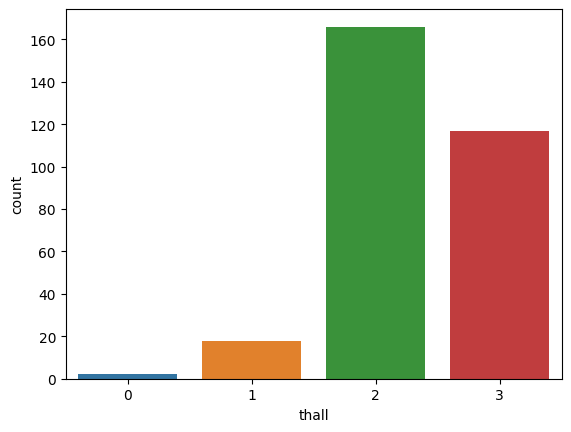

       TARGET_MEAN
thall             
0         0.500000
1         0.333333
2         0.783133
3         0.239316


   output      Ratio
1     165  54.455446
0     138  45.544554
#################################################################################


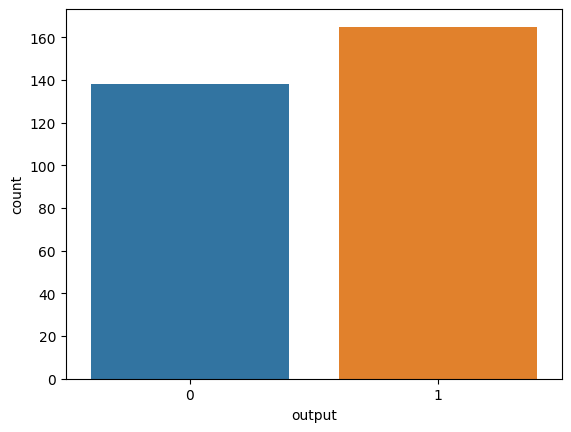

        TARGET_MEAN
output             
0               0.0
1               1.0




In [11]:
for col in cat_cols:
  cat_summary(df, col, True)
  target_summary_with_cat(df, "output", col)

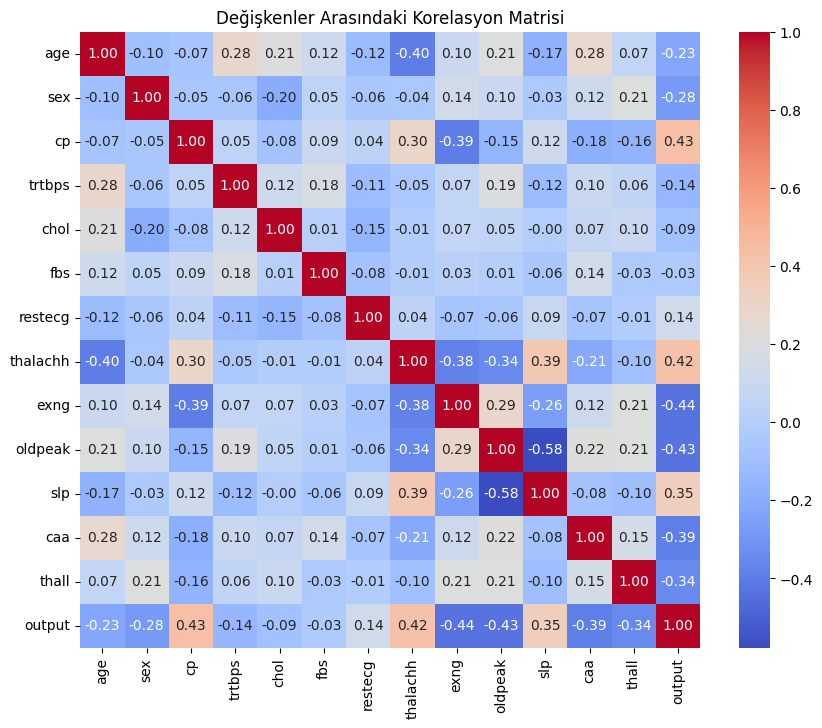

In [12]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Değişkenler Arasındaki Korelasyon Matrisi")
plt.show()


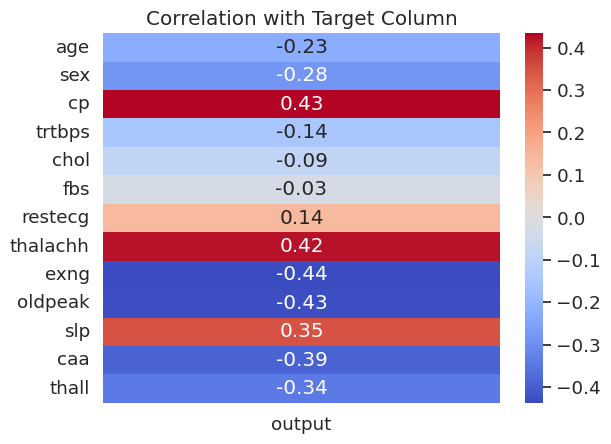

In [13]:
corr = df.corr()

target_corr = corr['output'].drop('output')

sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Target Column')
plt.show()

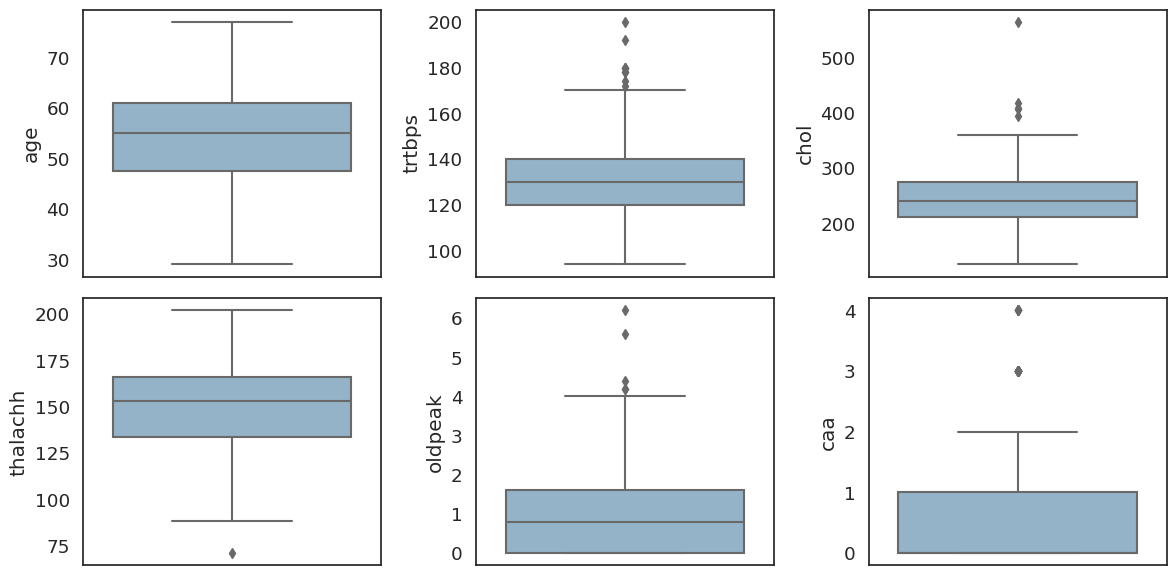

In [14]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])

plt.tight_layout()

In [15]:
for col in num_cols:
    if df[df[col] == 0].shape[0] > 0:  # Eğer sütunda en az bir 0 değeri varsa
        print(col)
#oldpeak
#caa
#Her iki durumda da, "0" değerleri sağlıklı veya normal koşulları temsil edebilir.Bu değerlerin 0 olması sorun ifade etmiyor.


oldpeak
caa


In [16]:
#Tekrarlanan satır var mı?
df.duplicated().sum()
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
164   38    1   2     138   175    0        1       173     0      0.0    2   

     caa  thall  output  
164    4      2       1  


In [17]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()
check_df(df)

######################################  Shape  ##################################
(302, 14)
######################################  Types  ##################################
age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object
######################################  Head  ###################################
   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      

In [18]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [23]:

X, y = df.drop(["output"],axis = 1), df["output"]

# Veriyi eğitim ve test setlerine bölelim.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini oluşturalım ve eğitelim
model = LogisticRegression()
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapalım
y_pred = model.predict(X_test)

# Modelin doğruluğunu değerlendirelim
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy}')

# Hata matrisini görüntüleyelim
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Model Accuracy: 0.8524590163934426
Confusion Matrix:
[[24  5]
 [ 4 28]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
